In [ ]:
#Get the data

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 7.64 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# check what files are in the Pbmed_20K
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/


dev.txt  test.txt  train.txt


In [ ]:
#start our exp using 20K dataset with no. replaced with @sign
data_dir= "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
# preprocess data, create function to readthe lines of a doc

def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list
  Args :
  filename:  a string containing the target filepath.
  Returns: A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()


In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstaract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like target, label, the text of the sentences,
  how many sentences are in the current abstract and what sentence number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 567 ms, sys: 102 ms, total: 669 ms
Wall time: 880 ms


In [ ]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
#distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

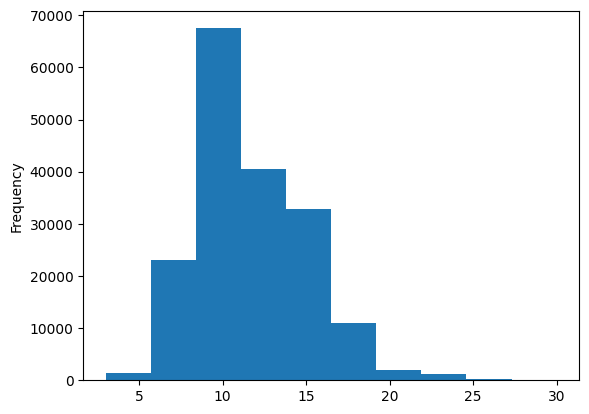

In [ ]:
#let's check the length of different lines
train_df.total_lines.plot.hist();

In [ ]:
# get lists of sentences

train_sentences =train_df ["text"].tolist()
val_sentences =val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:14]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Make numerics labels


In [ ]:
#one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

#label encode labels
#Extract labels ("target" columsn) and encode them into integers

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
#get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

#Model 0 Baseline Naive-Bayes TF-IDF

In [ ]:
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

his_0 = model_0.fit(X=train_sentences,
                    y =train_labels_encoded)

In [ ]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# import functions
#!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

In [ ]:
#from helper_function import calculate_results
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
baseline_results = calculate_results(val_labels_encoded,
                                     baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
#Preparing our data for deep sequence models

import numpy as np
from tensorflow.keras import layers

In [ ]:
#how long is each sentence on avg?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

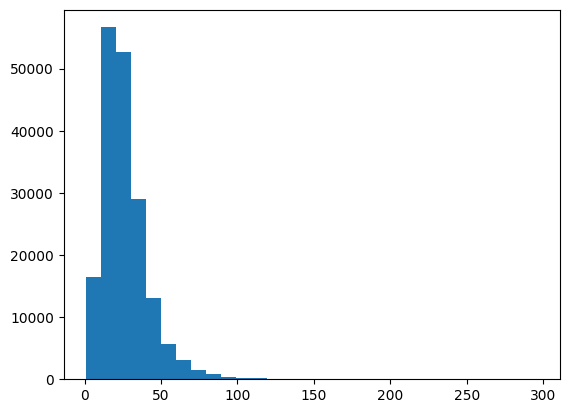

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=30);

In [ ]:
#how long of a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [ ]:
#max sentence
max(sent_lens)

296

#text vectorizer layer


In [ ]:
#how many words are there in our vocab?
max_tokens = 68000

In [ ]:
#create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length = output_seq_len)


In [ ]:
#adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
#test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\n Length of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
 scheduling regular sexual activity and exercise may be an effective tool for the behavioral management of sexual side effects of antidepressants

 Length of text: 21

Vectorized text: [[10987  1004   809   190     3   177    91    36    26   137  1136    11
      2   706   287     4   809   493    71     4  3830     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
#how many words in our training vocabulary
rct_20k_text_vocab =text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [ ]:
#create custom text embedding
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero =True,
                               name="Embedding layer")

In [ ]:
#show example embedding
print(f"Sentence before vectorizatio:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding) :\ {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"sentence after embedding: \n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorizatio:
 scheduling regular sexual activity and exercise may be an effective tool for the behavioral management of sexual side effects of antidepressants

Sentence after vectorization (before embedding) :\ [[10987  1004   809   190     3   177    91    36    26   137  1136    11
      2   706   287     4   809   493    71     4  3830     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

sentence after embedding: 
 [[[ 0.01665851  0.00752972 -0.02490973 ...  0.02376917 -0.03382403
    0.04673657]
  [ 0.0104139   0.0360903   0.03986496 ... -0.0103107   0.03285501
   -0.03769876]
  [ 0.00434297 -0.01837007 -0.00600597 ... -0.04101706 -0.04876727
    0.00017856]
  ...
  [ 0.01778033  0.04063567  0.00664227 ...  0.00971467 -0.01289997
    0.03139589]
  [ 0.01778033  0.04063567  0.00664227 ...  0.00971467 -0.01289

In [ ]:

# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:

# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

Model 1 conv1d

In [ ]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding")

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embedding = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embedding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 =tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
len(valid_dataset)*0.1

94.5

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))


Epoch 1/3
562/562 [==============================] - 44s 58ms/step - loss: 0.9127 - accuracy: 0.6401 - val_loss: 0.6775 - val_accuracy: 0.7437
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.6530 - accuracy: 0.7590 - val_loss: 0.6248 - val_accuracy: 0.7743
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6133 - accuracy: 0.7761 - val_loss: 0.5901 - val_accuracy: 0.7896


In [ ]:
#make predictions and evaluate our model
model_1.evaluate(valid_dataset)


945/945 [==============================] - 4s 4ms/step - loss: 0.5931 - accuracy: 0.7893


[0.5930656790733337, 0.7892889976501465]

In [ ]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[4.4280693e-01, 1.4883611e-01, 8.9106530e-02, 2.8780234e-01,
         3.1448137e-02],
        [4.5735565e-01, 2.6255748e-01, 1.4092446e-02, 2.5791675e-01,
         8.0777463e-03],
        [1.3098493e-01, 5.4742587e-03, 1.4099487e-03, 8.6210024e-01,
         3.0666131e-05],
        ...,
        [7.0786018e-06, 6.1749003e-04, 7.3277473e-04, 4.9686014e-06,
         9.9863774e-01],
        [6.5754436e-02, 5.0921267e-01, 8.3086886e-02, 7.6156013e-02,
         2.6578996e-01],
        [1.4076492e-01, 7.0455784e-01, 5.4794289e-02, 3.5977192e-02,
         6.3905649e-02]], dtype=float32),
 (30212, 5))

In [ ]:
#convert pre probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(val_labels_encoded, model_1_preds)

In [ ]:
model_1_results, baseline_results

({'accuracy': 78.92890242287832,
  'precision': 0.7860640824053818,
  'recall': 0.7892890242287832,
  'f1': 0.787103240945942},
 {'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294})

#model 2  Feature Extraction pretrained word embeddings




In [ ]:
import tensorflow_hub as hub
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                 trainable =False,
                                 name="USE")


In [ ]:
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: \n {random_train_sentence}")
use_embedded_sentence = embedding_layer([random_train_sentence])
print(f"Sentence after embedding: \n {use_embedded_sentence[0][:30]}")
len(use_embedded_sentence[0])

Random sentence: 
 in hematology patients , there was no evidence that @ - or @-day plts were inferior to @ - to @-day plts , as measured by proportion of patients with successful transfusions , bleeding events , or interval to next transfusion .
Sentence after embedding: 
 [-0.06382504  0.01259575  0.02254396 -0.00723014  0.0042769  -0.01284942
  0.06870134 -0.03542884  0.0181058   0.05363542  0.08523272  0.04764076
  0.0327269   0.04665315  0.05191854 -0.03701475 -0.08524504 -0.06481941
  0.01228659  0.01292222  0.0812932   0.06642241 -0.01005762 -0.02141091
  0.00486841  0.02591705 -0.05224595  0.01101104 -0.02788125 -0.07074757]


512

In [ ]:
inputs =layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics="accuracy")


In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
his_2 = model_2.fit(train_dataset,
                    epochs=3,
                    steps_per_epoch=int(0.1*len(train_dataset)),
                    validation_data=valid_dataset,
                    validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9145 - accuracy: 0.6520 - val_loss: 0.7933 - val_accuracy: 0.6908
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7678 - accuracy: 0.7022 - val_loss: 0.7524 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7519 - accuracy: 0.7131 - val_loss: 0.7360 - val_accuracy: 0.7164


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7404 - accuracy: 0.7152


[0.7403737902641296, 0.7152125239372253]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[4.4430947e-01, 3.4462368e-01, 2.5497784e-03, 2.0146722e-01,
        7.0498087e-03],
       [3.6400732e-01, 4.7699600e-01, 5.6075337e-03, 1.5055399e-01,
        2.8351480e-03],
       [2.2457258e-01, 1.3901727e-01, 1.6979575e-02, 5.8454251e-01,
        3.4888152e-02],
       ...,
       [1.9372823e-03, 5.5531072e-03, 4.9662419e-02, 9.3357277e-04,
        9.4191360e-01],
       [4.2098574e-03, 4.5569383e-02, 2.0636368e-01, 1.6296487e-03,
        7.4222738e-01],
       [1.6143809e-01, 2.3744906e-01, 5.3934222e-01, 6.4464160e-03,
        5.5324171e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(val_labels_encoded, model_2_preds)

In [ ]:
model_2_results

{'accuracy': 71.52124983450284,
 'precision': 0.715800793266763,
 'recall': 0.7152124983450284,
 'f1': 0.7123027003917115}

Model 3 Conv1D with character embeddings

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
def split_chars(text):
  return " ".join(list(text))


In [ ]:
split_chars(random_train_sentence)

'i n   h e m a t o l o g y   p a t i e n t s   ,   t h e r e   w a s   n o   e v i d e n c e   t h a t   @   -   o r   @ - d a y   p l t s   w e r e   i n f e r i o r   t o   @   -   t o   @ - d a y   p l t s   ,   a s   m e a s u r e d   b y   p r o p o r t i o n   o f   p a t i e n t s   w i t h   s u c c e s s f u l   t r a n s f u s i o n s   ,   b l e e d i n g   e v e n t s   ,   o r   i n t e r v a l   t o   n e x t   t r a n s f u s i o n   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars= [split_chars(sentence) for sentence in test_sentences]

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len =np.mean(char_lens)
mean_char_len

149.3662574983337

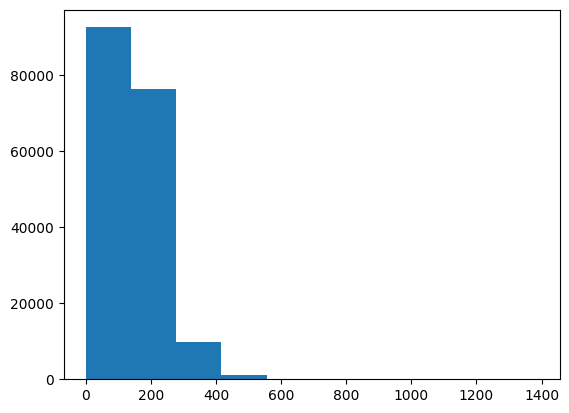

In [ ]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=10);

In [ ]:
#95percentile
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
#get all keyboard characters
random.choice(train_sentences)

'the extra radiation dose can be avoided in most patients older than age @ years .'

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
num_char_tokens = len(alphabet) + 2 # for space and UKN
char_vectorizer = TextVectorization(max_tokens = num_char_tokens,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")


In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of diff char in char vocab: {len(char_vocab)}")
print(f"5 most common {char_vocab[:5]}")
print(f"5 least common {char_vocab[-5:]}")

Number of diff char in char vocab: 28
5 most common ['', '[UNK]', 'e', 't', 'i']
5 least common ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_chars = random.choice(train_chars)
print(f"charified text:\n {random_train_chars}")
print(f"Len of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\n Vectorized chars:\n {vectorized_chars}")
print(f"\n len of vectorized chars: {len(vectorized_chars[0])}")

charified text:
 i n   s i n g l e - i n c i s i o n   l a p a r o s c o p i c   s u r g e r y   (   s i l s   )   ,   o p e r a t i n g   t h r o u g h   @   i n c i s i o n   p r e s e n t s   e r g o n o m i c   c h a l l e n g e s   .
Len of random_train_chars: 96

 Vectorized chars:
 [[ 4  6  9  4  6 18 12  2  4  6 11  4  9  4  7  6 12  5 14  5  8  7  9 11
   7 14  4 11  9 16  8 18  2  8 19  9  4 12  9  7 14  2  8  5  3  4  6 18
   3 13  8  7 16 18 13  4  6 11  4  9  4  7  6 14  8  2  9  2  6  3  9  2
   8 18  7  6  7 15  4 11 11 13  5 12 12  2  6 18  2  9  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0 

#creating char level emedding

In [ ]:
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 25 ,# thi sis the size of the char embedding in the paper
                              mask_zero = True,
                              name="char_embed")

In [ ]:
print(f"charifies text: \n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"shape: {char_embed_example.shape}")

charifies text: 
 i n   s i n g l e - i n c i s i o n   l a p a r o s c o p i c   s u r g e r y   (   s i l s   )   ,   o p e r a t i n g   t h r o u g h   @   i n c i s i o n   p r e s e n t s   e r g o n o m i c   c h a l l e n g e s   .

embedded chars (after vectorization and embedding):
 [[[ 1.4076460e-02 -4.7814138e-03 -4.3327119e-02 ...  2.6065771e-02
   -4.1252635e-02  3.3510413e-02]
  [-3.1931959e-02  4.9162451e-02  3.0384425e-02 ... -4.1938312e-03
   -4.9883712e-02  1.7914388e-02]
  [-7.8640878e-05  1.2167715e-02  9.7305402e-03 ...  1.7704058e-02
    3.4018304e-02 -6.4749494e-03]
  ...
  [ 2.3572061e-02 -8.9984424e-03  2.1202341e-03 ... -4.8058342e-02
   -3.9092731e-02  6.6061020e-03]
  [ 2.3572061e-02 -8.9984424e-03  2.1202341e-03 ... -4.8058342e-02
   -3.9092731e-02  6.6061020e-03]
  [ 2.3572061e-02 -8.9984424e-03  2.1202341e-03 ... -4.8058342e-02
   -3.9092731e-02  6.6061020e-03]]]

shape: (1, 290, 25)


#building a conv1D model

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors =char_vectorizer(inputs)
char_embedding = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embedding)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss= "categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="Accuracy")

In [ ]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [ ]:
#create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

test_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
his_3 = model_3.fit(train_char_dataset,
                    steps_per_epoch=int(0.1*len(train_char_dataset)),
                    epochs=3,
                    validation_data=val_char_dataset,
                    validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2969 - Accuracy: 0.4764 - val_loss: 1.0679 - val_Accuracy: 0.5891
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0154 - Accuracy: 0.5991 - val_loss: 0.9438 - val_Accuracy: 0.6380
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9260 - Accuracy: 0.6350 - val_loss: 0.8718 - val_Accuracy: 0.6672


In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)

945/945 [==============================] - 3s 3ms/step


In [ ]:
model_3_preds= tf.argmax(model_3_pred_probs, axis=1)

In [ ]:
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 1, ..., 4, 4, 1])>

In [ ]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)

In [ ]:
model_3_results

{'accuracy': 66.00688468158347,
 'precision': 0.6527759726163479,
 'recall': 0.6600688468158348,
 'f1': 0.6503839775244715}

Model 4 combining token and char embeddings

In [ ]:
token_inputs = layers.Input(shape=[], dtype="string", name="token_input")
token_embeddings = embedding_layer(token_inputs)
token_output= layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output)

char_inputs = layers.Input(shape=(1,), dtype="string", name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

#concatinate token and char embedding
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,char_model.output])

#create output layers adding in dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs= output_layer,
                         name="model_4_token_char_embedding")

In [ ]:
model_4.summary()

Model: "model_4_token_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['toke

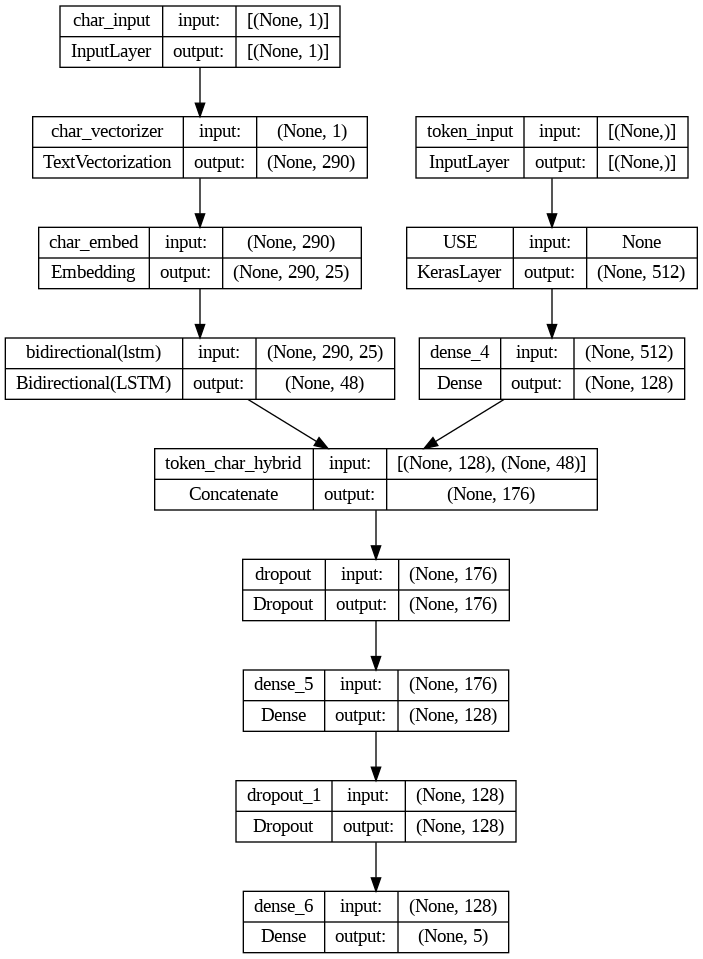

In [ ]:
#plot the model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
model_4.compile(loss= "categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

#combining token and character data into a tf.data Dataset

In [ ]:

# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
his_4 = model_4.fit(train_char_token_dataset,
                    steps_per_epoch =int(0.1*len(train_char_token_dataset)),
                    epochs=3,
                    validation_data=val_char_token_dataset,
                    validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 43s 57ms/step - loss: 0.9865 - accuracy: 0.6092 - val_loss: 0.7754 - val_accuracy: 0.7038
Epoch 2/3
562/562 [==============================] - 28s 51ms/step - loss: 0.7975 - accuracy: 0.6901 - val_loss: 0.7129 - val_accuracy: 0.7320
Epoch 3/3
562/562 [==============================] - 26s 45ms/step - loss: 0.7713 - accuracy: 0.7064 - val_loss: 0.6820 - val_accuracy: 0.7370


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6885 - accuracy: 0.7367


[0.6885069012641907, 0.7366940379142761]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 23s 21ms/step


array([[4.53378141e-01, 3.13573658e-01, 5.63235814e-03, 2.16693968e-01,
        1.07218893e-02],
       [3.58116776e-01, 4.42833304e-01, 5.10139298e-03, 1.90781564e-01,
        3.16697708e-03],
       [3.34797949e-01, 1.12856284e-01, 4.71137092e-02, 4.71882552e-01,
        3.33494209e-02],
       ...,
       [4.43161378e-04, 6.69583306e-03, 6.55773208e-02, 1.92627864e-04,
        9.27091062e-01],
       [4.96787112e-03, 4.23988998e-02, 1.55092150e-01, 2.25891685e-03,
        7.95282125e-01],
       [2.92194694e-01, 4.23769414e-01, 2.10729674e-01, 3.71787436e-02,
        3.61273885e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)

In [ ]:
model_4_results

{'accuracy': 73.66940288627035,
 'precision': 0.7366091633361024,
 'recall': 0.7366940288627035,
 'f1': 0.7339215590423026}

#model_5 transfer learning with token embeddings and char embeddings and position embeddings(feature engineering)


In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
#create positional embeddings
#how many different line no. are their
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

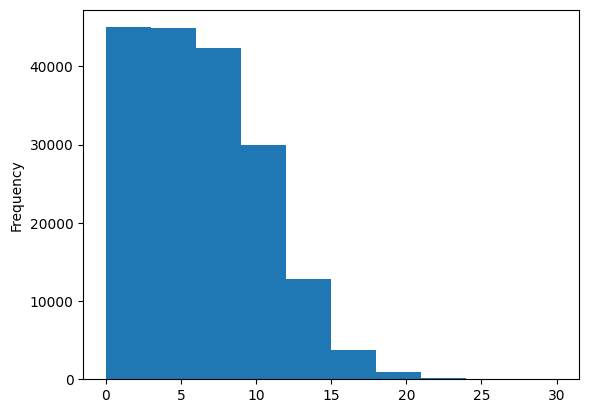

In [ ]:
#check disrtibution
train_df.line_number.plot.hist()

In [ ]:
#use TF to create one_hot_encoded tensors of line_number column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot[:14]

<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [ ]:
#encoding total lines
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

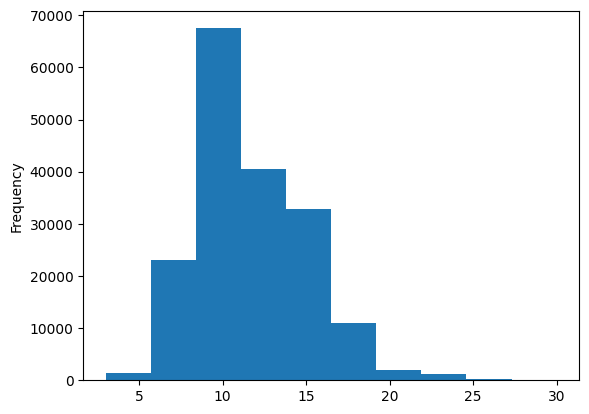

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
#check the coverage
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [ ]:
train_total_lines_one_hot[:20]

<tf.Tensor: shape=(20, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

#building a Tribrid embedding model

1. Create a token level model
2. create a char level model
3. create a model for the "line number" feature
4. create a model for the "total_line" feature
5. Combine the outputs of 1 and 2 using concatenate
6. combine the outputs of 3, 4 adn 5 using concatenate
7. create an output layer to accept the tribrid embedding and output label probabilities
8. combine the inputs of 1,2,3,4 and outputs of into tf.keras.model

In [ ]:
#1.token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

#2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

#3. Line numbers model
line_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_inputs")
x = layers.Dense(32, activation="relu")(line_inputs)
line_number_model = tf.keras.Model(line_inputs,x)

#4. total lines model
total_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_inputs)
total_line_model =tf.keras.Model(total_inputs, y)

#5 Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z= layers.Dropout(0.5)(z)

#6 combine positional embedding with combined token and char embedding
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 z])

#7 create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

#8 put it all together
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_line_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer)

In [ ]:
model_5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_inputs[0][0]']     

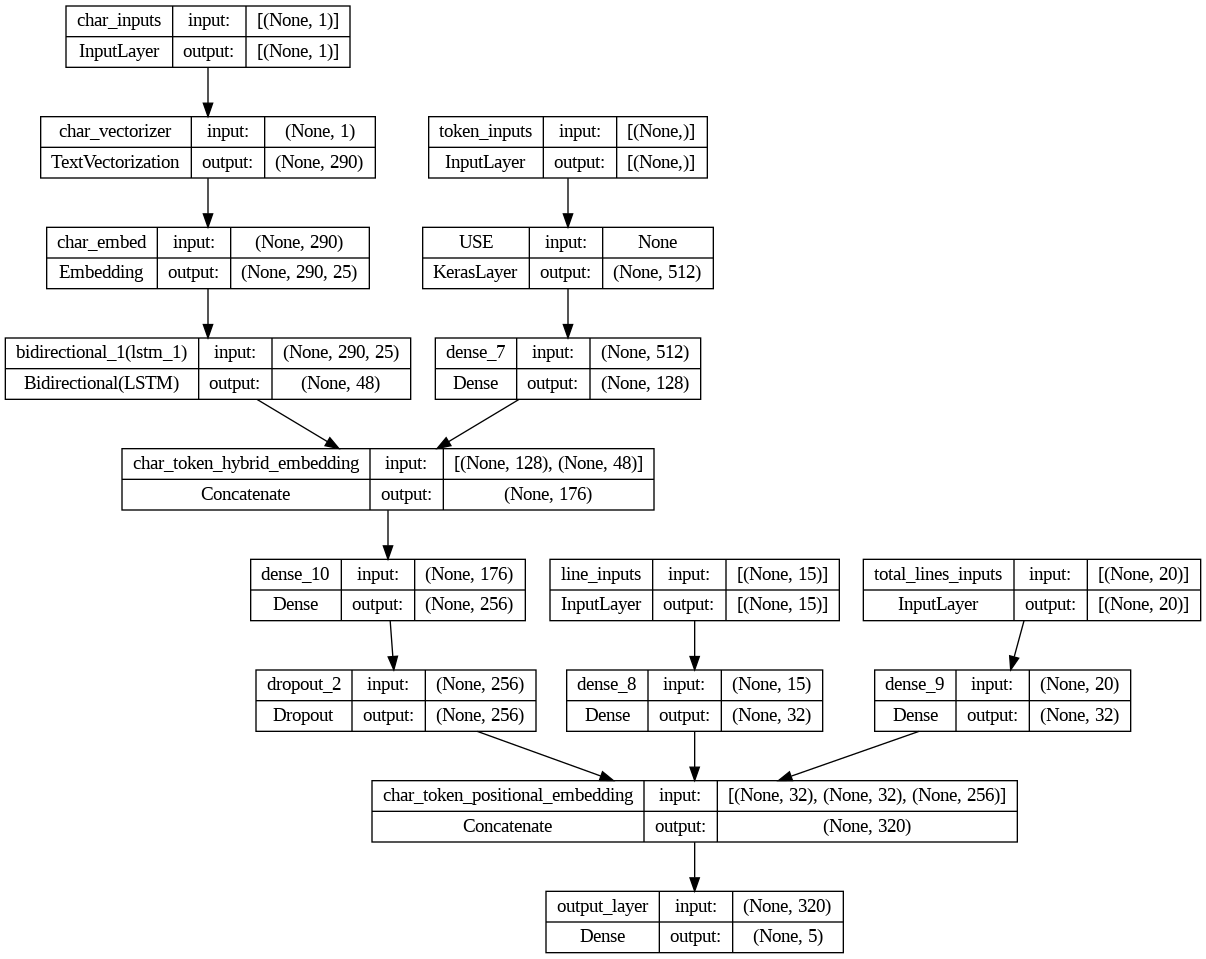

In [ ]:
#plot the model
from keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [ ]:
#compile
model_5.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

#create tribrid embedding datasets using data


In [ ]:
#create training and validation datasets
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
his_5 = model_5.fit(train_pos_char_token_dataset,
                    steps_per_epoch =int(0.5*len(train_pos_char_token_dataset)),
                    epochs=5,
                    validation_data=val_pos_char_token_dataset,
                    validation_steps=int(0.5*len(val_pos_char_token_dataset)))

Epoch 1/5
2813/2813 [==============================] - 153s 51ms/step - loss: 0.9786 - accuracy: 0.8051 - val_loss: 0.9204 - val_accuracy: 0.8423
Epoch 2/5
2813/2813 [==============================] - 141s 50ms/step - loss: 0.9280 - accuracy: 0.8415 - val_loss: 0.9069 - val_accuracy: 0.8454
Epoch 3/5
   1/2813 [..............................] - ETA: 1:33 - loss: 0.8915 - accuracy: 0.8750

2813/2813 [==============================] - 21s 7ms/step - loss: 0.8915 - accuracy: 0.8750 - val_loss: 0.9069 - val_accuracy: 0.8452


In [ ]:
model_5.evaluate(val_pos_char_token_dataset)
model_5_preds_probs = model_5.predict(val_pos_char_token_dataset)
model_5_preds_probs

945/945 [==============================] - 21s 19ms/step


array([[0.58071935, 0.1021544 , 0.01448109, 0.27761078, 0.02503442],
       [0.5651463 , 0.13228714, 0.07109945, 0.21586226, 0.01560482],
       [0.388422  , 0.09667745, 0.10723841, 0.34757563, 0.06008653],
       ...,
       [0.02182462, 0.06546424, 0.02116489, 0.02928193, 0.8622643 ],
       [0.02120678, 0.33072457, 0.05874543, 0.02440203, 0.56492126],
       [0.09163503, 0.7830069 , 0.05584939, 0.02723123, 0.04227743]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_preds_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(val_labels_encoded,model_5_preds)

In [ ]:
model_5_results

{'accuracy': 84.78088176883357,
 'precision': 0.8494714371297013,
 'recall': 0.8478088176883357,
 'f1': 0.8446700829642041}

#comparing model results


In [ ]:
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embeddings":model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embeddings": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.928902,0.786064,0.789289,0.787103
model_2_pretrained_token_embedding,71.521250,0.715801,0.715212,0.712303
model_3_custom_char_embeddings,66.006885,0.652776,0.660069,0.650384
model_4_hybrid_char_token_embedding,73.669403,0.736609,0.736694,0.733922
model_5_pos_char_token_embeddings,84.780882,0.849471,0.847809,0.844670


In [ ]:
#reduce accuracy to smae scale
all_model_results["accuracy"] = all_model_results["accuracy"]/100


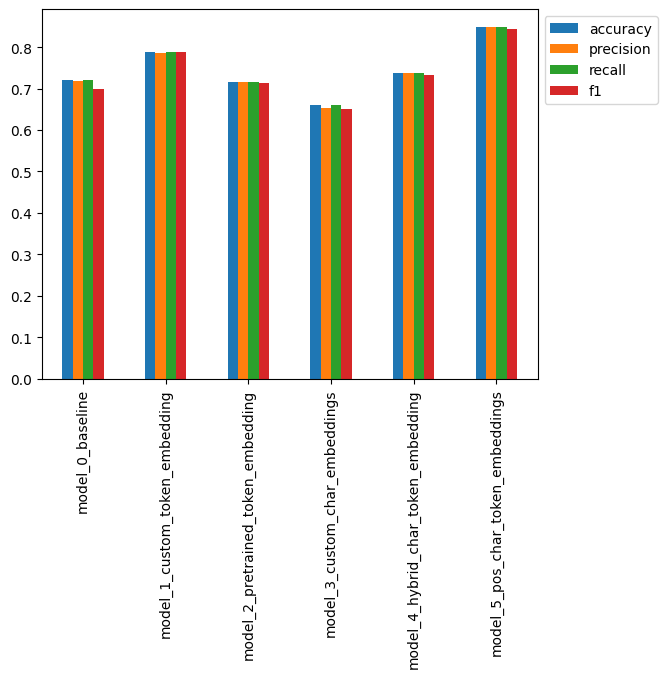

In [ ]:
all_model_results.plot(kind="bar").legend(bbox_to_anchor=(1.0,1.0));

<Axes: >

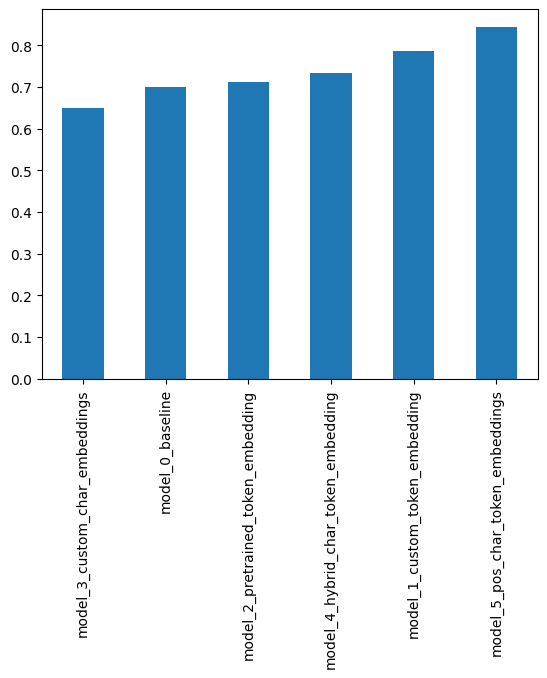

In [ ]:
#sort models results by f1score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar")

#save and load model

In [ ]:
model_5.save("skimlit_tribrid_model")

In [ ]:
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
loaded_pred_probs =loaded_model.predict(val_pos_char_token_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)


945/945 [==============================] - 29s 31ms/step


In [ ]:
loaded_results = calculate_results(val_labels_encoded,loaded_preds)
loaded_results

{'accuracy': 84.78088176883357,
 'precision': 0.8494714371297013,
 'recall': 0.8478088176883357,
 'f1': 0.8446700829642041}

In [ ]:
assert model_5_results == loaded_results